In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using Theano backend.


In [10]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    string = re.sub(r"\s{2,}", "", string)
    string = re.sub(r"[0-9]+", "", string)



    string = re.sub("#", " ", string)
    string = re.sub("!", " ", string)
    string = re.sub("@", " ", string)
    
    
    return string.strip().lower()

In [3]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [6]:
# reading data

df=pd.read_csv("Tweets.txt",delimiter="\t")

df = df.dropna()
df = df.reset_index(drop=True)


df.columns = ['message', 'class']
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['class'])))


Shape of dataset  (9693, 2)
Index(['message', 'class'], dtype='object')
No. of unique classes 4


In [7]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [19]:
df

message  class
0     أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...      3
1     البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...      0
2     #الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...      2
3     الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...      1
4     #انتخبوا_العرص #انتخبوا_البرص #مرسى_رئيسى #اين...      1
5     امير عيد هو اللي فعلا يتقال عليه ستريكر صريح #...      3
6     أحكي لكم قصة حدثت بين شاب و أحد الفتيات كان بي...      2
7     أدعوكم لحضور الندوة الثقافية الأربعاء مركز اعد...      2
8     عودة جماعة الإخوان إلى الحياة السياسية بنفس وض...      0
9     _ علاج السكري #اف_نتشورال #السعودية #العراق #ا...      2
10    الوطن | موجتان متعاقبتان لمقاومة صناعة الاستبد...      2
11    شاهد - آخر كلام: إضراب العاملين بمصلحة الطب ال...      2
12                الصداقة تزرع الحياة أزهارًا #مي_زيادة      3
13    الإصرار علي الإستفتاء في ظل وطن ممزق وغليان شع...      0
14    #مصطفى_حسني #على_طريق_الله #روح_العبادة #الوضو...      2
15    دضياء رشوان: أن الدكتور عبد المنعم أبو الفتوح ...      3
16    للبيادة نكهات عديدة - باسم يوسف :: بوابة الشرو...      2
17    د أبو الفتوح في العاشرة مساء : منصب رئيس الجمه...      2
18    انشاء مراكز أهلية وخاصة لتأهيل وتدريب المعلمين...      2
19    أدين بشدة تقديم كل صاحب رأي أو ناشط سياسي للمح...      0
20    د عمار علي حسن,تحديات مسودة الدستور والانتخابا...      2
21    مش هنسالك وانتا واقف جنبى بتطلب القصاص وكلاب ا...      1
22    1 العنف مدان، ضد منشآت عامة أو خاصة، ضد مجمع م...      0
23                               اللي ما يعرفش يقول عدس      2
24    إلى زملائي المحامين الراغبين في الانضمام لمباد...      3
25    إآبني آلمستقبلي ^_^ تشرب #حشيش عآإدي = تصآإحب ...      1
26    هواجس العام الجديد - سادسنا كيف يرتقى الأداء ا...      2
27    ماشاء الله، لا قوّة إلا بالله مؤشر بورصة #قطر ...      2
28    هل هناك حضارة دون وجود المرأة؟ يجب أن نثق في ق...      3
29    سابحث غدا مع رئيس تشاد موقف البلدين من #سد_الن...      2
...                                                 ...    ...
9663  كلما رأيت أطفالا مشردين ، جائعين ، محاصرين ، ل...      0
9664  #اﻷهلى هو اللى دايما مفرحنى الحمد لله على نعمة...      3
9665                    آن الأوان ترحلي يادولة العكاكين      0
9666  بعد فضيحة التعاقد مع شركة اسرائيلية لحماية قنا...      0
9667  ثلاثين يونيو موجة ثورية ضد الفاشل مرسي والجماع...      0
9668  الوطن | أسباب رفض الحوار وسبل تجاوزها | عمرو ح...      2
9669  مجهولون يشعلون النار في سيارتين بـ #المحلة_الك...      2
9670  الشوكولاته والقهوه ، فيروز وحليم ، الشتا واللي...      3
9671  تدوينة رائعة من خالد بهي الدين ترد على أكاذيب ...      1
9672                        #خلق_جميل الاحسان الى الجار      3
9673  مداخلة نجيب ساويرس مع الإبراشيي وتعليقه على إس...      3
9674  #سيدنا_النبي كان طيب الرائحة، وإذا صافحه أحد ظ...      3
9675        صوره جميله لعشب استاد #الامارات ! #ارسنال "      3
9676  مبرووووك ل#سواريز فاز بجائزة #أوسكار بعد آدائه...      3
9677  الاخوان سيضاعفون اعتصاماتهم الإجرامية وغاراتهم...      0
9678  البنزين دونت ميكس ويذ الكحول زي الضمير دونت مي...      0
9679  الحكومة الحالية غير قادرة على إتخاذ قرارات وهي...      0
9680  حكومة #مصر توافق على ترخيص 50 قناة تنصيرية بين...      0
9681  بعض الناس ينطبق عليهم القول لو أمطرت السماء حر...      0
9682  وزير البترول المصري، م أسامة كمال، وحوار خاص ح...      2
9683    اقرا ؟ خطر مشاهدة الافلام الاباحية _تفتك الدماغ      0
9684  ذكرى استعادة #سيناء ستمثل عيدا للعسكرية والدبل...      3
9685  ما يقال عن صدور "مذكرة تفسيرية" للإعلان الدستو...      0
9686  بالفيديو عاكشة: والله هيفاء وهبى ست مش طرية وا...      0
9687  مرسى لم يعد رئيسًا لخروجه على الشرعية وقراراته...      0
9688  والغاز مش مدعوم يا إنسان؟ وماذا عن الأسمنت وال...      0
9689  اغلاق كل الساحات والميادين الكبرى لمنع صلاة ال...      0
9690  #الشروق "الداخلية": 400 ألف مواطن تقدموا لأداء...      2
9691      #هتحبك_لو صحتها من النوم علشان تقولها بحبك ;)      3
9692     كل شى كتبته غلط كل شى حسبته غلط فى #الامتحانات      0

[9693 rows x 2 columns]

In [12]:
texts = []
labels = []


for idx in range(df.message.shape[0]):
    text = df.message[idx]
    texts.append(clean_str(str(text)))

for idx in df['class']:
    labels.append(idx)

'كل شى كتبته غلط كل شى حسبته غلط فى #الامتحانات'

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 38391


In [16]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Shape of Data Tensor: (9693, 1000)
Shape of Label Tensor: (9693, 4)


In [18]:
embeddings_index = {}
f = open('./glove.6B/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         93300     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 17)                3417      
Total params: 257,517
Trainable params: 257,517
Non-trainable params: 0
_________________________________________________________________


In [1]:
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

NameError: name 'ModelCheckpoint' is not defined

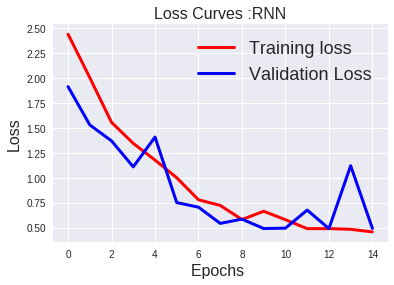

In [20]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

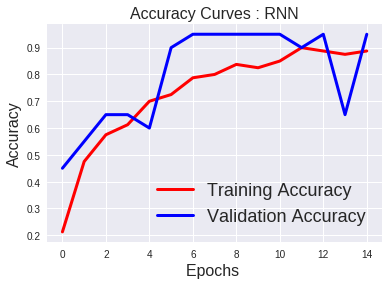

In [21]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()